## **Import Libraries**

In [1]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import UpSampling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

2024-04-05 07:56:22.939612: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 07:56:22.939722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 07:56:23.226086: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Loading and Preprocessing the Dataset**

### **Using Tuberculosis Images only to generate Synthetic data**

In [2]:
# Function to create augmented image by applying a random transformation
def augment_image(image):
    random_transformation = np.random.choice([
        lambda img: img,  # No transformation
        lambda img: cv2.flip(img, 1),  # Horizontal flip
        lambda img: cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE),  # 90 degree rotation
        lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2HSV),  # Color space change
       
    ])
    return random_transformation(image)

In [3]:
# Function to load and preprocess images with data augmentation
def load_images_with_augmentation(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.png'):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (image_height, image_width))

            # Create augmented images
            augmented_images = [img, augment_image(img)]
            images.extend(augmented_images)

    return images

In [4]:
# Load the dataset
input_dir = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis'
image_height = 256
image_width = 256

# Load and augment tuberculosis images
tuberculosis_images = load_images_with_augmentation(input_dir)

In [5]:
import cv2

# Load an image
img = cv2.imread('/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-100.png')

# Check the size of the image
height, width, channels = img.shape

print("Height:", height)
print("Width:", width)
print("Channels:", channels)

Height: 512
Width: 512
Channels: 3


## **Displaying Tuberculosis Images from the Dataset**

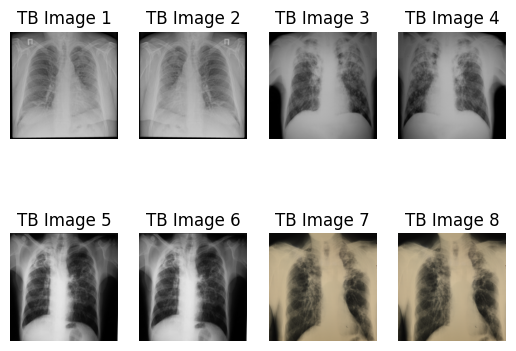

In [6]:
import matplotlib.pyplot as plt

# Assuming tuberculosis_images is a list containing image data

# Determine the number of rows and columns for subplot layout
num_rows = 2
num_cols = 4
num_images_to_display = num_rows * num_cols

# Ensure num_images_to_display does not exceed the number of images available
num_images_available = len(tuberculosis_images)
num_images_to_display = min(num_images_to_display, num_images_available)

# Display the images
for i in range(num_images_to_display):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(tuberculosis_images[i], cmap='gray')  # Assuming grayscale images
    plt.title(f"TB Image {i+1}")
    plt.axis('off')

plt.show()

In [6]:
x_ray_data = np.array(tuberculosis_images)

## **Normalizing Pixel Values**

In [7]:
# Normalize pixel values to [0, 1]
x_ray_data = x_ray_data / 255.0

## **Train Test Split**

In [8]:
# Split the dataset into training and validation sets
x_train, x_val, _, _ = train_test_split(x_ray_data, x_ray_data, test_size=0.2, random_state=42)

In [9]:
print(len(x_train))
print(len(x_val))

1120
280


In [10]:
# Define the dimensions of your images
image_height, image_width, num_channels = x_ray_data.shape[1:]

* image_height: Represents the height of each image in pixels.
* image_width: Represents the width of each image in pixels.
* num_channels: Represents the number of channels in each image. For grayscale images, this value would be 1. For RGB images, this value would be 3 (since they have red, green, and blue channels).

# **Define the architecture of the autoencoder**

In [11]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# Define the autoencoder architecture
def build_autoencoder(input_shape):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Change output channels to 3 for RGB images

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')  # Change loss function to mean squared error
    return autoencoder

# **Build the autoencoder model and Train the autoencoder**

In [12]:
# Build the autoencoder model
input_shape = x_train[0].shape
autoencoder = build_autoencoder(input_shape)

# **Generate synthetic data**

In [13]:
# from tensorflow.keras.callbacks import EarlyStopping

# # Define the early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)


# # Train the model with early stopping
# history = autoencoder.fit(x_train, x_train, epochs=100, validation_data=(x_val, x_val), callbacks=[early_stopping])

# Train the model without early stopping
history = autoencoder.fit(x_train, x_train, epochs=40, validation_data=(x_val, x_val))

Epoch 1/40


I0000 00:00:1712303831.229082     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


35/35 [==============================] - 19s 213ms/step - loss: 0.0320 - val_loss: 0.0067
Epoch 2/40
35/35 [==============================] - 4s 126ms/step - loss: 0.0047 - val_loss: 0.0029
Epoch 3/40
35/35 [==============================] - 4s 125ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 4/40
35/35 [==============================] - 4s 126ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 5/40
35/35 [==============================] - 4s 126ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 6/40
35/35 [==============================] - 4s 126ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/40
35/35 [==============================] - 4s 126ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/40
35/35 [==============================] - 4s 126ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/40
35/35 [==============================] - 4s 127ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/40
35/35 [==============================] - 4s 127ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 11/

In [14]:
synthetic_images = autoencoder.predict(x_train)

35/35 [==============================] - 1s 38ms/step


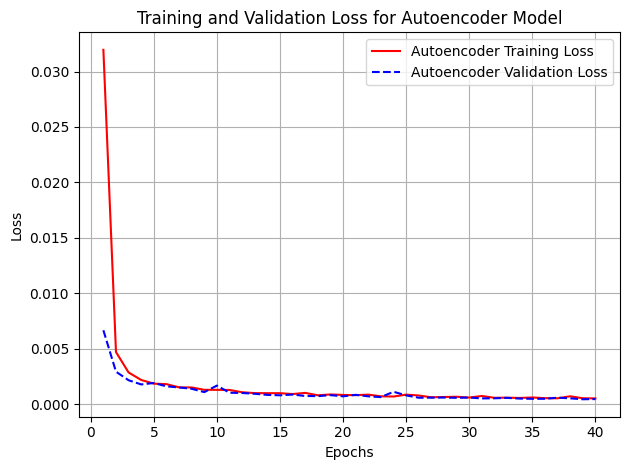

In [15]:
import matplotlib.pyplot as plt

def plot_loss(history):
    # Get training and validation loss from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot training and validation loss
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'r', label='Autoencoder Training Loss')
    plt.plot(epochs, val_loss, 'b--', label='Autoencoder Validation Loss')  # Using dashed lines for validation loss
    plt.title('Training and Validation Loss for Autoencoder Model')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)  # Add grid
    plt.tight_layout()  # Adjust layout
    plt.show()
    
# Plot training and validation loss
plot_loss(history)

# **Save synthetic images to a directory**

In [16]:
# Save synthetic images to a directory
output_dir = '/kaggle/working/synthetic_images/'

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save each synthetic image
for i, img in enumerate(synthetic_images):
    cv2.imwrite(os.path.join(output_dir, f"synthetic_image_{i}.png"), img)

# **Display the synthetic images**

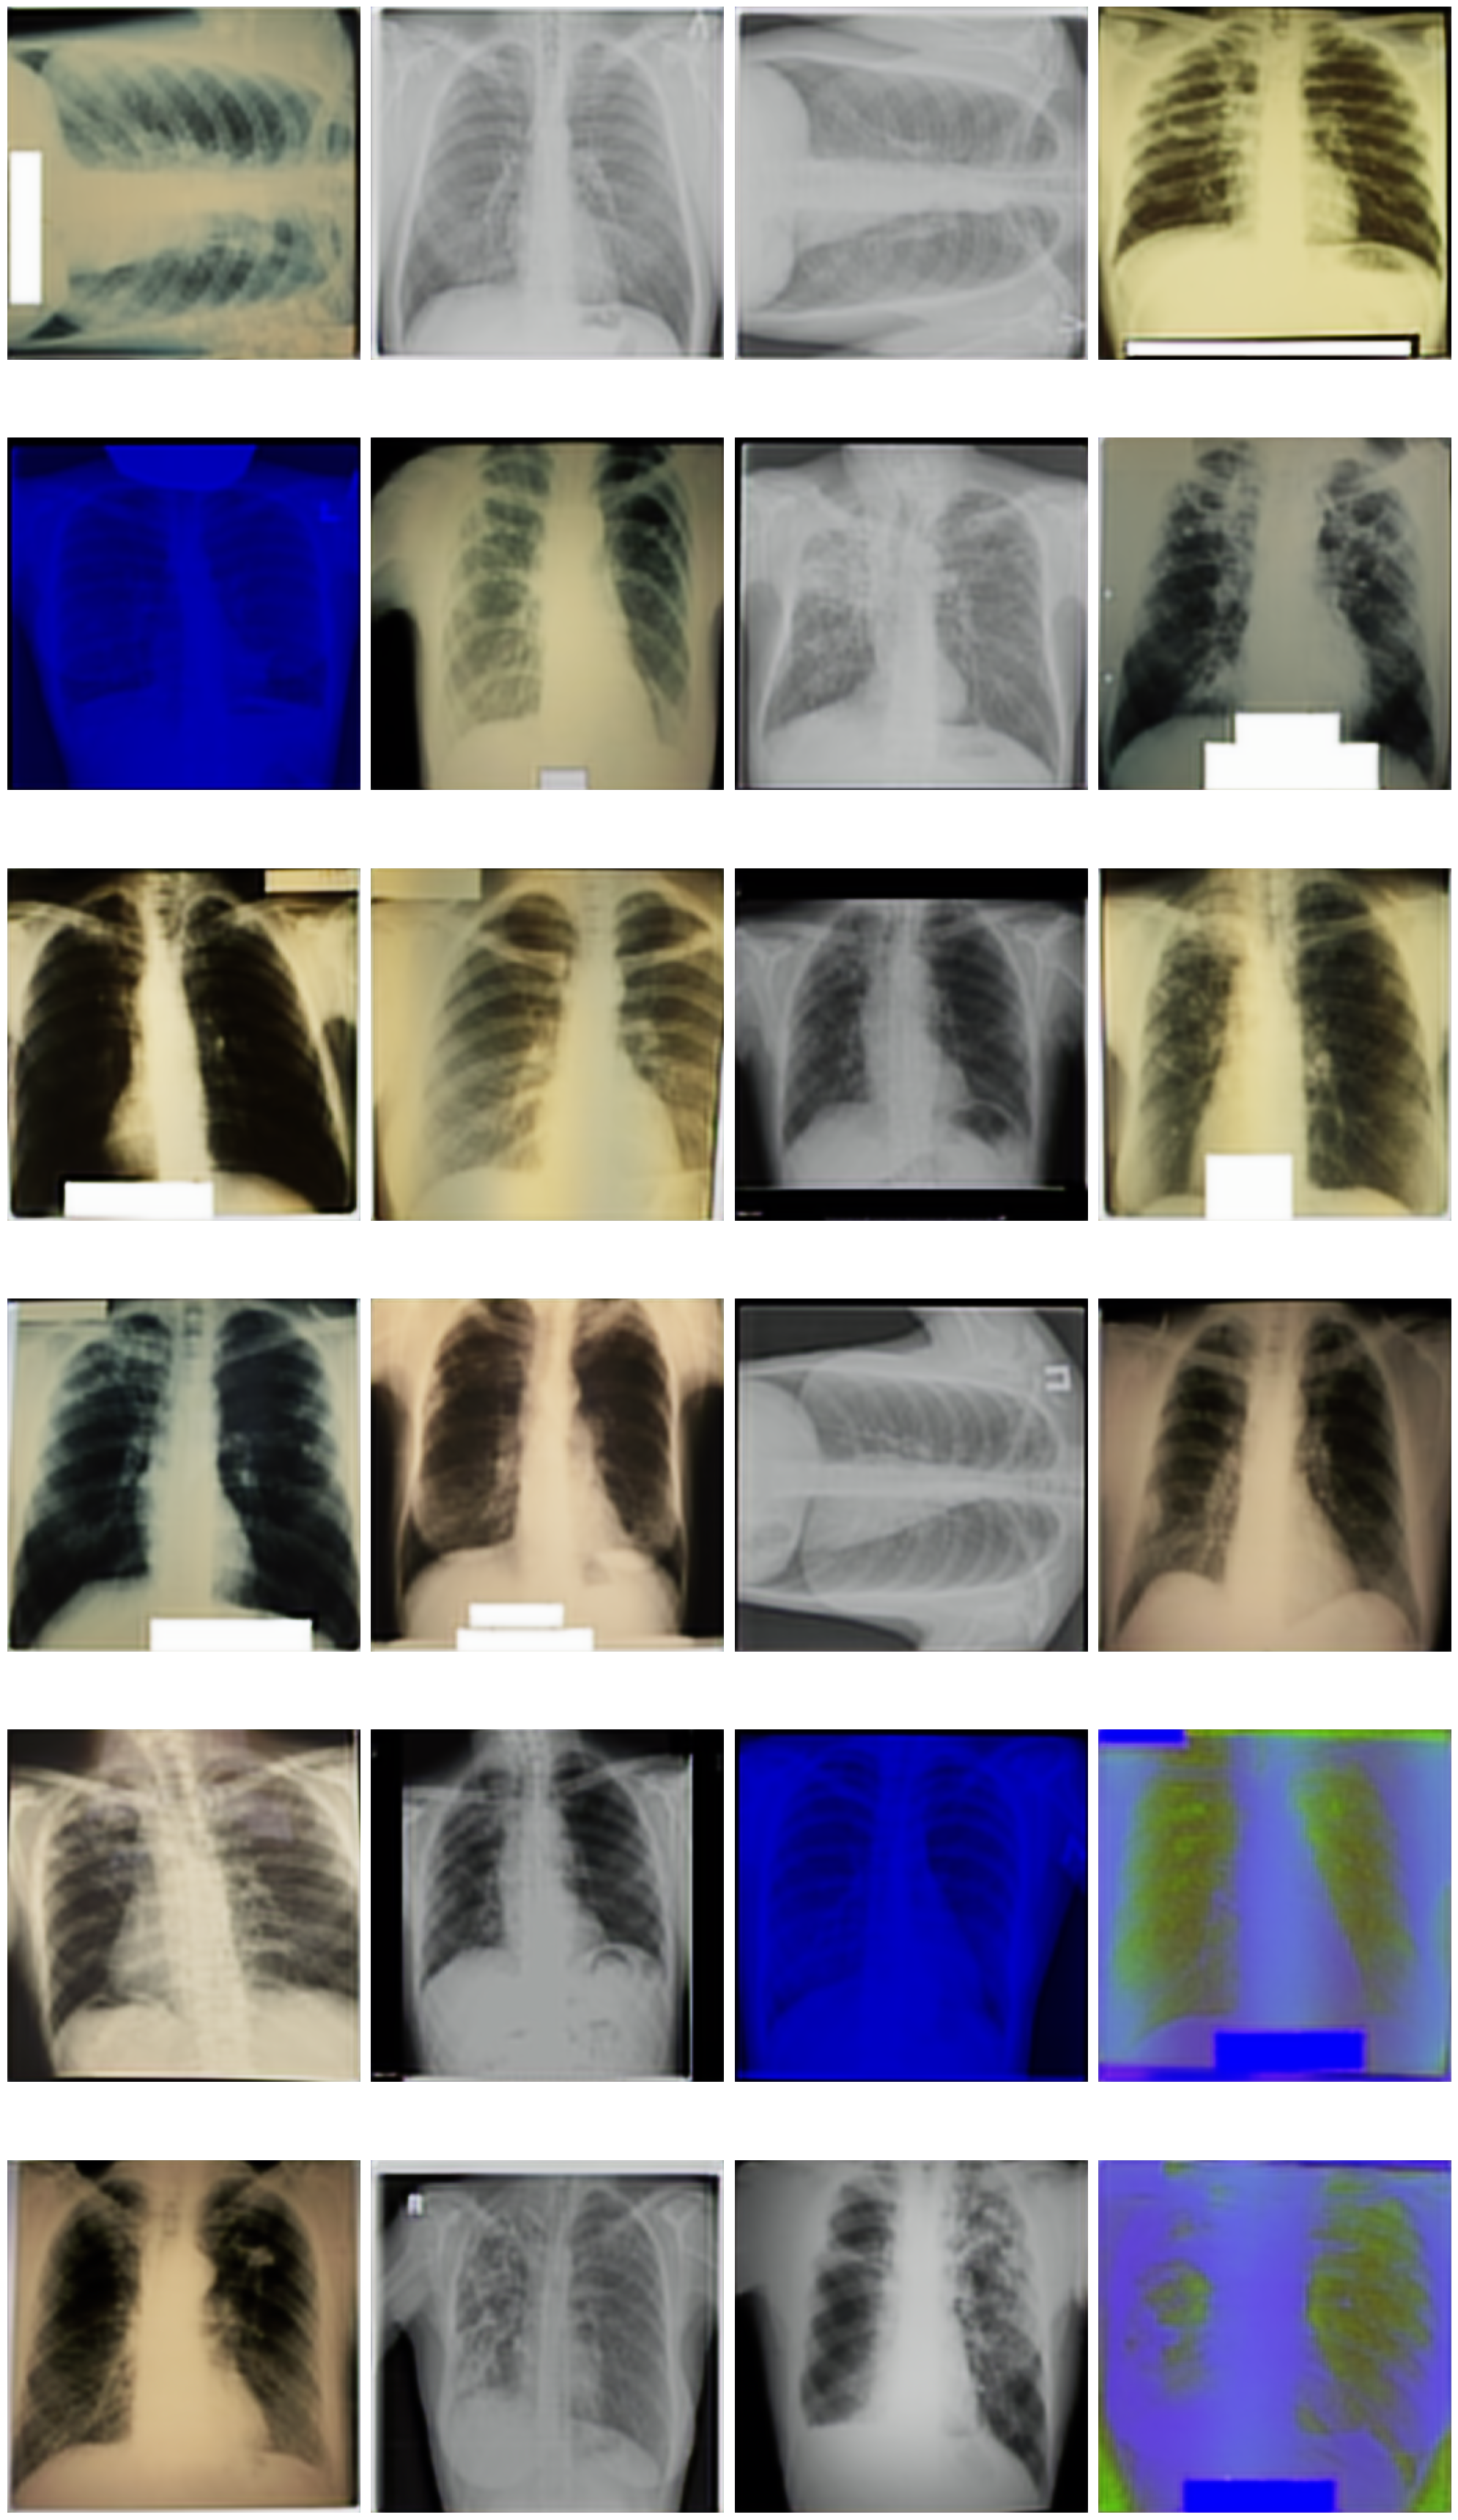

In [17]:
import math
import matplotlib.pyplot as plt

num_samples = 24

# Define the number of rows and columns
num_rows = math.ceil(num_samples / 4)
num_columns = 4

# Create a figure and axis object
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 6 * num_rows))

# Display the synthetic images
for i, ax in enumerate(axes.flat):
    if i < num_samples:
        row = i // num_columns
        col = i % num_columns
        ax.imshow(synthetic_images[i])
        ax.axis('off')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

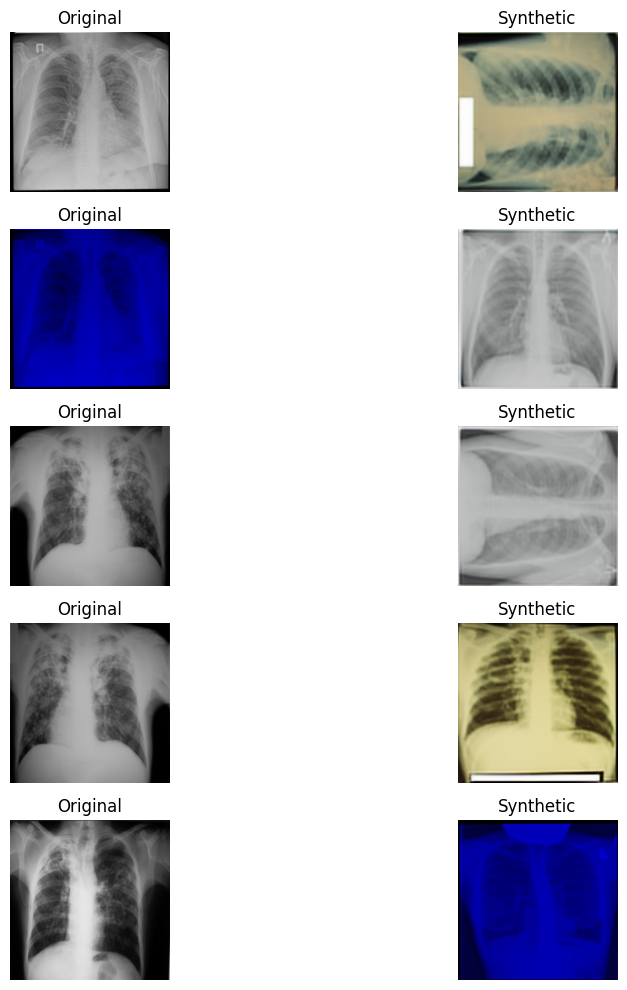

In [18]:
import matplotlib.pyplot as plt

def plot_images(original_images, synthetic_images, num_images=5):
    fig, axes = plt.subplots(num_images, 2, figsize=(12, 2*num_images))
    for i in range(num_images):
        axes[i, 0].imshow(original_images[i])
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(synthetic_images[i])
        axes[i, 1].set_title('Synthetic')
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

# Display the first 5 original and synthetic images
plot_images(x_ray_data[:5], synthetic_images[:5], num_images=5)

In [19]:
print(len(synthetic_images))  # Number of synthetic images generated
print(len(x_ray_data))  # Total number of original images used

1120
1400


In [20]:
# For original images, label = 0 (real)
# For synthetic images, label = 1 (fake)
original_labels = np.zeros(len(x_train))
synthetic_labels = np.ones(len(synthetic_images))

# Combine the Data
combined_images = np.concatenate((x_train, synthetic_images), axis=0)
combined_labels = np.concatenate((original_labels, synthetic_labels), axis=0)

In [21]:
# Shuffle the Data
shuffle_indices = np.random.permutation(len(combined_images))
combined_images = combined_images[shuffle_indices]
combined_labels = combined_labels[shuffle_indices]

In [22]:
from sklearn.model_selection import train_test_split

# Split the Data
x_train, x_test, y_train, y_test = train_test_split(combined_images, combined_labels, test_size=0.2, random_state=42)

In [23]:
len(x_test)

448

In [24]:
len(x_train)

1792

## **CNN Model with 13 layers**

In [26]:
from tensorflow.keras import layers, models

def build_cnn_with_batch_normalization(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Define input shape and number of classes
input_shape = (image_height, image_width, channels)  # Update with actual values
num_classes = 2  # Assuming binary classification

# Build the CNN model with batch normalization
cnn_model_with_batch_norm = build_cnn_with_batch_normalization(input_shape, num_classes)

# Show the model summary
cnn_model_with_batch_norm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_6 (Conv2D)           (None, 252, 252, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 126, 126, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 124, 124, 128)     73856     
                                                                 
 batch_normalization_1 (Bat  (None, 124, 124, 128)     5

In [27]:
# from tensorflow.keras.callbacks import EarlyStopping

# # Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

# # Compile the model
# cnn_model_with_batch_norm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Train the model with early stopping and validation splitting
# history = cnn_model_with_batch_norm.fit(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

# Compile the model
cnn_model_with_batch_norm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model without early stopping
history = cnn_model_with_batch_norm.fit(x_train, y_train, epochs=40, validation_split=0.2)


Epoch 1/40
45/45 [==============================] - 40s 532ms/step - loss: 39.4379 - accuracy: 0.6274 - val_loss: 87.0667 - val_accuracy: 0.5292
Epoch 2/40
45/45 [==============================] - 12s 263ms/step - loss: 15.0508 - accuracy: 0.8158 - val_loss: 257.9934 - val_accuracy: 0.5292
Epoch 3/40
45/45 [==============================] - 12s 260ms/step - loss: 10.0937 - accuracy: 0.8814 - val_loss: 172.8943 - val_accuracy: 0.5292
Epoch 4/40
45/45 [==============================] - 12s 258ms/step - loss: 5.2931 - accuracy: 0.9177 - val_loss: 500.6806 - val_accuracy: 0.5292
Epoch 5/40
45/45 [==============================] - 12s 257ms/step - loss: 2.0162 - accuracy: 0.9358 - val_loss: 403.2405 - val_accuracy: 0.5292
Epoch 6/40
45/45 [==============================] - 12s 257ms/step - loss: 2.8453 - accuracy: 0.9211 - val_loss: 413.5421 - val_accuracy: 0.5292
Epoch 7/40
45/45 [==============================] - 12s 259ms/step - loss: 1.7261 - accuracy: 0.9491 - val_loss: 153.4904 - val_

In [28]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model_with_batch_norm.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

14/14 [==============================] - 1s 63ms/step - loss: 0.1606 - accuracy: 0.9978
Test Loss: 0.1605655997991562
Test Accuracy: 0.9977678656578064


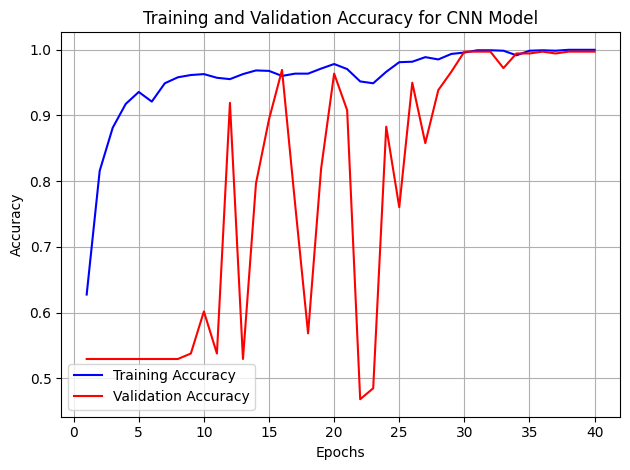

In [29]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    # Get training and validation accuracy from the history object
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Get the number of epochs
    epochs = range(1, len(train_accuracy) + 1)

    # Plotting the training and validation accuracy
    plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy for CNN Model')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)  # Add grid
    plt.tight_layout()  # Adjust layout
    plt.show()

# Plot training and validation accuracy for CNN
plot_accuracy(history)

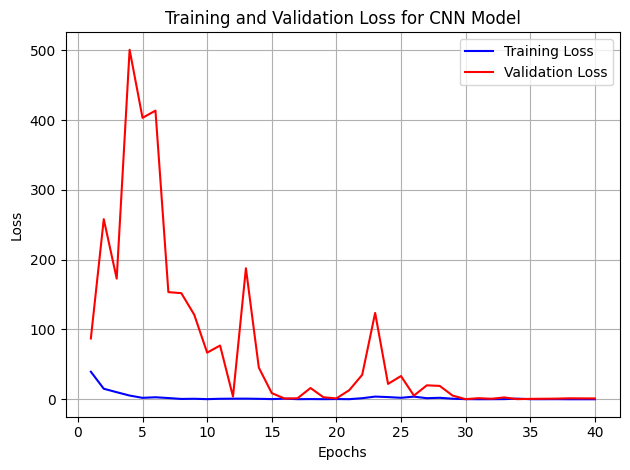

In [30]:
import matplotlib.pyplot as plt

def plot_loss(history):
    # Get training and validation loss from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get the number of epochs
    epochs = range(1, len(train_loss) + 1)

    # Plotting the training and validation loss
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss for CNN Model')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)  # Add grid
    plt.tight_layout()  # Adjust layout
    plt.show()

# Plot training and validation loss for CNN
plot_loss(history)

## **CNN Model with 8 Layers**

In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models, initializers
from tensorflow.keras.callbacks import EarlyStopping

# Define your simplified model architecture
def cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Define input shape and number of classes
input_shape = (image_height, image_width, channels)  # Update with actual values
num_classes = 2  # Assuming binary classification

# Build the CNN model
cnn_model = cnn_model(input_shape, num_classes)

# Show the model summary
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 128)      

In [32]:
# # Define the early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

# # Compile the model with Adam optimizer and sparse categorical crossentropy loss
# cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Train the model with early stopping and validation splitting
# history = cnn_model.fit(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

# Compile the model with Adam optimizer and sparse categorical crossentropy loss
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model without early stopping
history = cnn_model.fit(x_train, y_train, epochs=40, validation_split=0.2)


Epoch 1/40
45/45 [==============================] - 10s 146ms/step - loss: 1.0370 - accuracy: 0.5157 - val_loss: 0.6982 - val_accuracy: 0.4708
Epoch 2/40
45/45 [==============================] - 4s 79ms/step - loss: 0.6946 - accuracy: 0.4717 - val_loss: 0.6933 - val_accuracy: 0.4708
Epoch 3/40
45/45 [==============================] - 4s 79ms/step - loss: 0.6961 - accuracy: 0.5052 - val_loss: 0.6933 - val_accuracy: 0.4708
Epoch 4/40
45/45 [==============================] - 4s 79ms/step - loss: 0.6932 - accuracy: 0.5101 - val_loss: 0.6937 - val_accuracy: 0.4708
Epoch 5/40
45/45 [==============================] - 4s 79ms/step - loss: 0.6930 - accuracy: 0.5101 - val_loss: 0.6938 - val_accuracy: 0.4708
Epoch 6/40
45/45 [==============================] - 4s 79ms/step - loss: 0.6930 - accuracy: 0.5101 - val_loss: 0.6940 - val_accuracy: 0.4708
Epoch 7/40
45/45 [==============================] - 4s 79ms/step - loss: 0.6930 - accuracy: 0.5101 - val_loss: 0.6939 - val_accuracy: 0.4708
Epoch 8/40


In [33]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

14/14 [==============================] - 0s 26ms/step - loss: 0.4730 - accuracy: 0.7902
Test Loss: 0.47295594215393066
Test Accuracy: 0.7901785969734192


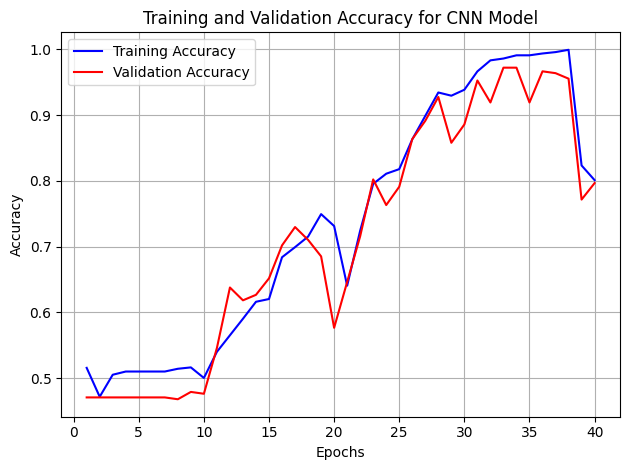

In [34]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    # Get training and validation accuracy from the history object
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Get the number of epochs
    epochs = range(1, len(train_accuracy) + 1)

    # Plotting the training and validation accuracy
    plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy for CNN Model')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)  # Add grid
    plt.tight_layout()  # Adjust layout
    plt.show()

# Plot training and validation accuracy
plot_accuracy(history)

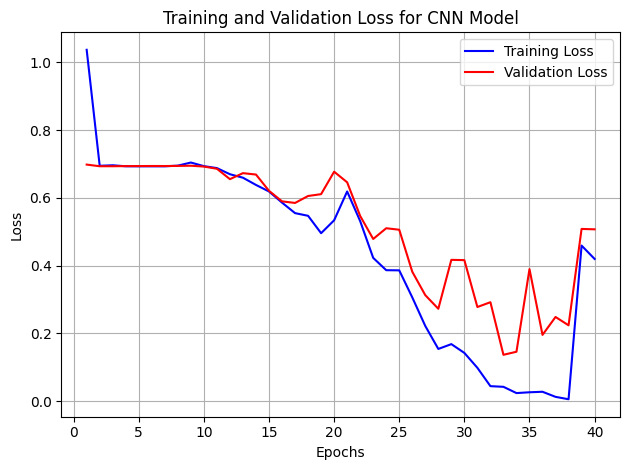

In [35]:
import matplotlib.pyplot as plt

def plot_loss(history):
    # Get training and validation loss from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get the number of epochs
    epochs = range(1, len(train_loss) + 1)

    # Plotting the training and validation loss
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss for CNN Model')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)  # Add grid
    plt.tight_layout()  # Adjust layout
    plt.show()

# Plot training and validation loss
plot_loss(history)

In [36]:
# Evaluate the model on the test data
test_loss, test_accuracy = cnn_model.evaluate(x_test, y_test)

print("Test Accuracy:", test_accuracy)

# Get predictions from the model
predictions = cnn_model.predict(x_test)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Count correctly classified images
correctly_classified = np.sum(predicted_labels == y_test)

# Calculate total number of test images
total_images = len(y_test)

# Calculate percentage of correctly classified images
percentage_correct = (correctly_classified / total_images) * 100

print("Number of correctly classified images:", correctly_classified)
print("Total number of test images:", total_images)
print("Percentage of correctly classified images:", percentage_correct, "%")


14/14 [==============================] - 0s 23ms/step - loss: 0.4730 - accuracy: 0.7902
Test Accuracy: 0.7901785969734192
14/14 [==============================] - 0s 21ms/step
Number of correctly classified images: 354
Total number of test images: 448
Percentage of correctly classified images: 79.01785714285714 %


## **VGG16 Model**

In [37]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [38]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Flatten, Dense

def build_vgg16(input_shape, num_classes):
    # Load the VGG16 model pre-trained on ImageNet without the top layer (include_top=False)
    base_model = VGG16(weights=None, include_top=False, input_shape=input_shape)
    
    # Load pre-trained weights from the local file path
    weights_path = '/kaggle/input/vgg16-weights-path/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
    base_model.load_weights(weights_path)
    
    # Freeze the layers of the VGG16 model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Customize the top layers for your specific task
    x = base_model.output
    x = Flatten()(x)  # Flatten the output tensor from convolutional layers
    x = Dense(256, activation='relu')(x)  # Add a fully connected layer with ReLU activation
    x = Dense(num_classes, activation='softmax')(x)  # Add a classification head with softmax activation
    
    # Create a new model
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

In [39]:
# Example usage:
input_shape = (224, 224, 3)  # Input shape of VGG16
num_classes = 2  
vgg16_model = build_vgg16(input_shape, num_classes)

# Show the model summary
vgg16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [40]:
import cv2

# Resize input images to match the expected input shape of the model
def resize_images(images):
    resized_images = []
    for image in images:
        resized_image = cv2.resize(image, (224, 224))  # Resize each image to (224, 224)
        resized_images.append(resized_image)
    return np.array(resized_images)

# Resize training and testing images
x_train_resized = resize_images(x_train)
x_test_resized = resize_images(x_test)

# Preprocess resized images
x_train_preprocessed = preprocess_input(x_train_resized)
x_test_preprocessed = preprocess_input(x_test_resized)

In [41]:
# # Compile the VGG16 model with appropriate optimizer and loss function
# vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Train the VGG16 model with early stopping and validation splitting
# history = vgg16_model.fit(x_train_preprocessed, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

# Compile the VGG16 model with appropriate optimizer and loss function
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the VGG16 model without early stopping
history = vgg16_model.fit(x_train_preprocessed, y_train, epochs=40, validation_split=0.2)

Epoch 1/40
45/45 [==============================] - 30s 434ms/step - loss: 2.0701 - accuracy: 0.4969 - val_loss: 0.7727 - val_accuracy: 0.4708
Epoch 2/40
45/45 [==============================] - 8s 171ms/step - loss: 0.7817 - accuracy: 0.4976 - val_loss: 0.7910 - val_accuracy: 0.4708
Epoch 3/40
45/45 [==============================] - 7s 167ms/step - loss: 0.7177 - accuracy: 0.4906 - val_loss: 0.7655 - val_accuracy: 0.4708
Epoch 4/40
45/45 [==============================] - 7s 165ms/step - loss: 0.7095 - accuracy: 0.5010 - val_loss: 0.6940 - val_accuracy: 0.5320
Epoch 5/40
45/45 [==============================] - 7s 162ms/step - loss: 0.7171 - accuracy: 0.4983 - val_loss: 0.6958 - val_accuracy: 0.4847
Epoch 6/40
45/45 [==============================] - 7s 160ms/step - loss: 0.7077 - accuracy: 0.5283 - val_loss: 0.6965 - val_accuracy: 0.4763
Epoch 7/40
45/45 [==============================] - 7s 159ms/step - loss: 0.7233 - accuracy: 0.4864 - val_loss: 0.7608 - val_accuracy: 0.4708
Epoch

In [42]:
# Evaluate the model on test data
loss, accuracy = vgg16_model.evaluate(x_test_preprocessed, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

14/14 [==============================] - 2s 126ms/step - loss: 0.6937 - accuracy: 0.4911
Test Loss: 0.6937144994735718
Test Accuracy: 0.4910714328289032


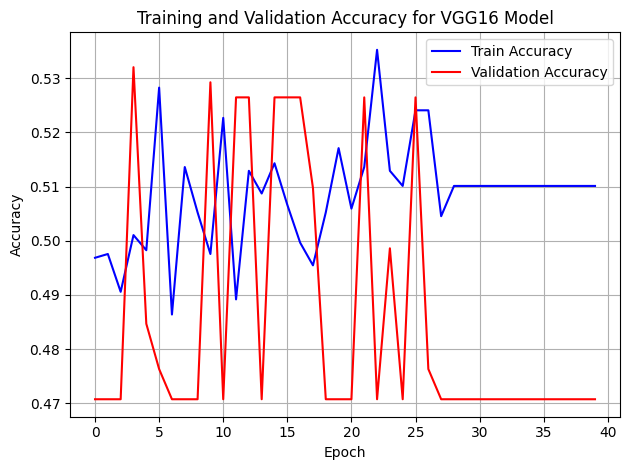

In [43]:
def plot_accuracy(history):
    # Plotting training and validation accuracy
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Training and Validation Accuracy for VGG16 Model')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)  # Add grid
    plt.tight_layout()  # Adjust layout
    plt.show()
    # Plot training & validation accuracy
plot_accuracy(history)

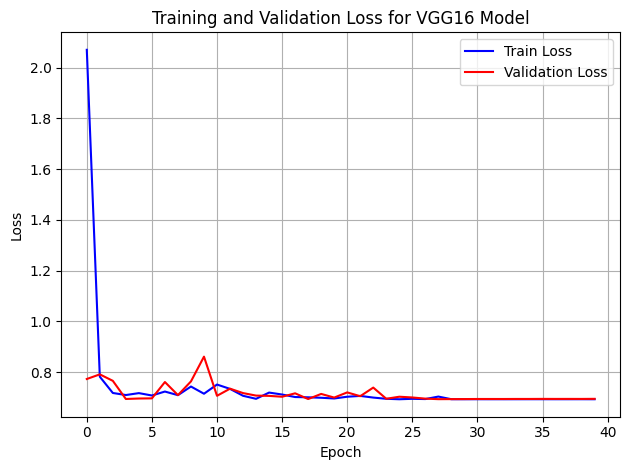

In [44]:
def plot_loss(history):
    # Plotting training and validation loss
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.title('Training and Validation Loss for VGG16 Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)  # Add grid
    plt.tight_layout()  # Adjust layout
    plt.show()
    
# Plot training & validation loss
plot_loss(history)

## **Use bias and weight to reset before running, for accuracy.**

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define your simplified model architecture
def cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Function to reset the weights and biases of the model
def reset_weights(model):
    session = tf.compat.v1.keras.backend.get_session()
    for layer in model.layers:
        if hasattr(layer, 'kernel') and hasattr(layer, 'bias'):
            if layer.kernel.initializer is not None:
                layer.kernel.initializer.run(session=session)
            if layer.bias.initializer is not None:
                layer.bias.initializer.run(session=session)

# Define input shape and number of classes
input_shape = (image_height, image_width, channels)  
num_classes = 2  

# Build the CNN model
cnn_model = cnn_model(input_shape, num_classes)

# Reset the weights and biases of the model
reset_weights(cnn_model)

# Show the model summary
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 128)       0

In [26]:
# # Define the early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

# # Compile the model with Adam optimizer and sparse categorical crossentropy loss
# cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Train the model with early stopping and validation splitting
# history = cnn_model.fit(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

# Compile the model with Adam optimizer and sparse categorical crossentropy loss
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model without early stopping
history = cnn_model.fit(x_train, y_train, epochs=40, validation_split=0.2)

Epoch 1/40
45/45 [==============================] - 12s 157ms/step - loss: 1.0212 - accuracy: 0.5094 - val_loss: 0.6914 - val_accuracy: 0.5125
Epoch 2/40
45/45 [==============================] - 4s 78ms/step - loss: 0.6893 - accuracy: 0.5345 - val_loss: 0.6565 - val_accuracy: 0.6462
Epoch 3/40
45/45 [==============================] - 4s 78ms/step - loss: 0.6518 - accuracy: 0.6232 - val_loss: 0.6442 - val_accuracy: 0.6462
Epoch 4/40
45/45 [==============================] - 4s 78ms/step - loss: 0.6073 - accuracy: 0.6629 - val_loss: 0.5797 - val_accuracy: 0.6630
Epoch 5/40
45/45 [==============================] - 4s 78ms/step - loss: 0.5218 - accuracy: 0.7397 - val_loss: 0.5012 - val_accuracy: 0.7939
Epoch 6/40
45/45 [==============================] - 3s 78ms/step - loss: 0.4926 - accuracy: 0.7606 - val_loss: 0.4490 - val_accuracy: 0.7994
Epoch 7/40
45/45 [==============================] - 4s 78ms/step - loss: 0.3820 - accuracy: 0.8381 - val_loss: 0.4475 - val_accuracy: 0.7939
Epoch 8/40


In [27]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

14/14 [==============================] - 0s 27ms/step - loss: 0.1307 - accuracy: 0.9665
Test Loss: 0.1306697279214859
Test Accuracy: 0.9665178656578064


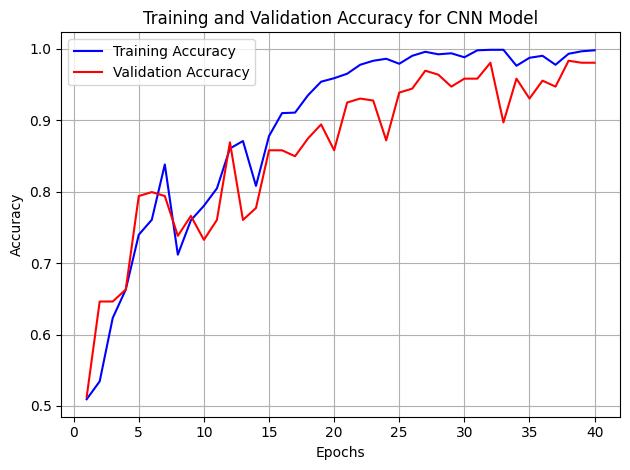

In [28]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    # Get training and validation accuracy from the history object
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Get the number of epochs
    epochs = range(1, len(train_accuracy) + 1)

    # Plotting the training and validation accuracy
    plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy for CNN Model')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)  # Add grid
    plt.tight_layout()  # Adjust layout
    plt.show()

# Plot training and validation accuracy for CNN
plot_accuracy(history)

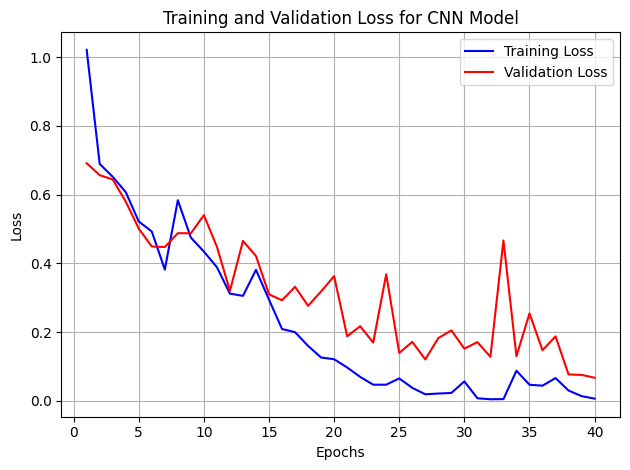

In [29]:
import matplotlib.pyplot as plt

def plot_loss(history):
    # Get training and validation loss from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get the number of epochs
    epochs = range(1, len(train_loss) + 1)

    # Plotting the training and validation loss
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss for CNN Model')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)  # Add grid
    plt.tight_layout()  # Adjust layout
    plt.show()

# Plot training and validation loss for CNN
plot_loss(history)

In [30]:
# Evaluate the model on the test data
test_loss, test_accuracy = cnn_model.evaluate(x_test, y_test)

print("Test Accuracy:", test_accuracy)

# Get predictions from the model
predictions = cnn_model.predict(x_test)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Count correctly classified images
correctly_classified = np.sum(predicted_labels == y_test)

# Calculate total number of test images
total_images = len(y_test)

# Calculate percentage of correctly classified images
percentage_correct = (correctly_classified / total_images) * 100

print("Number of correctly classified images:", correctly_classified)
print("Total number of test images:", total_images)
print("Percentage of correctly classified images:", percentage_correct, "%")

14/14 [==============================] - 0s 24ms/step - loss: 0.1307 - accuracy: 0.9665
Test Accuracy: 0.9665178656578064
14/14 [==============================] - 0s 20ms/step
Number of correctly classified images: 433
Total number of test images: 448
Percentage of correctly classified images: 96.65178571428571 %


14/14 [==============================] - 0s 25ms/step


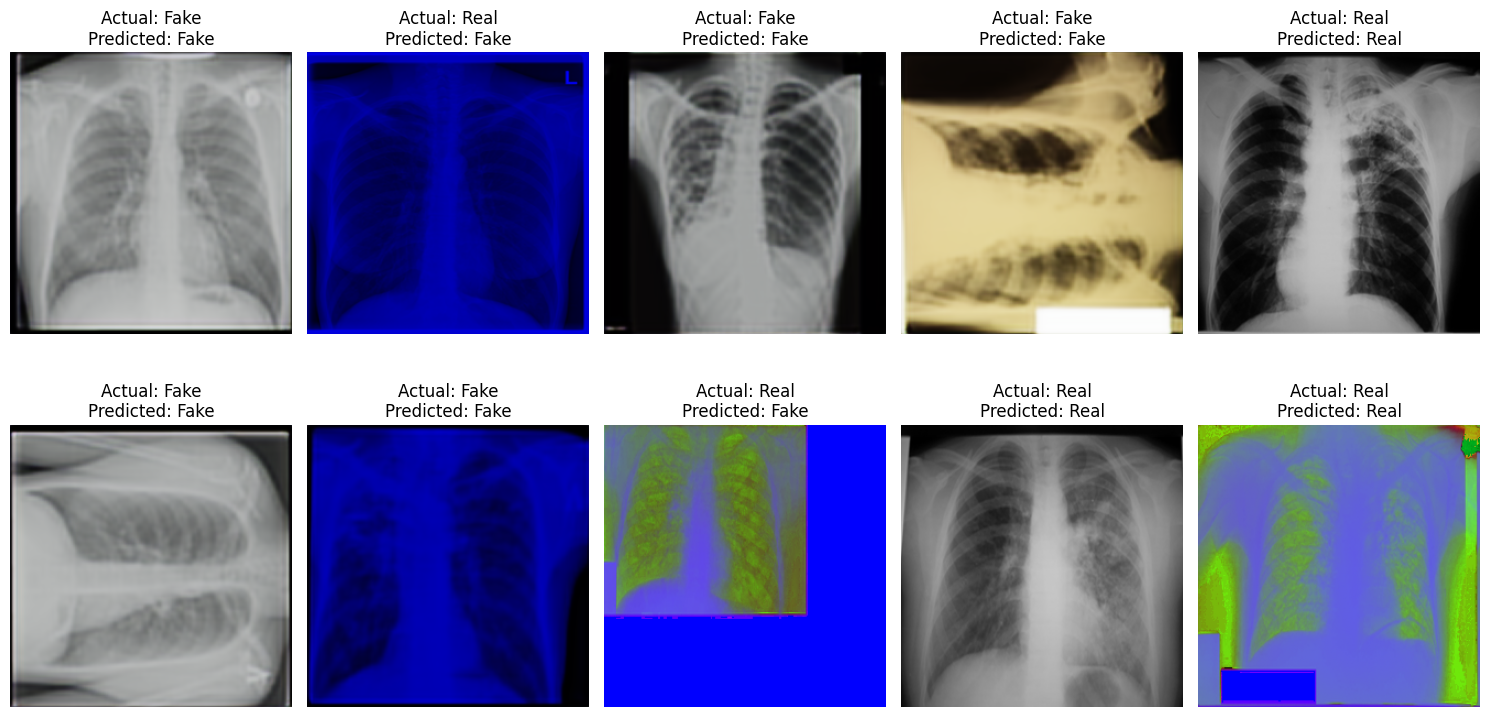

In [33]:
import matplotlib.pyplot as plt

# Define class labels
class_labels = ['Real', 'Fake']

# Get predictions from the model
predictions = cnn_model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)

# Randomly select some images and their corresponding labels
num_images_to_plot = 10
random_indices = np.random.choice(len(x_test), num_images_to_plot, replace=False)
sample_images = x_test[random_indices]
sample_actual_labels = y_test[random_indices]
sample_predicted_labels = predicted_labels[random_indices]

# Plot the images
plt.figure(figsize=(15, 8))
for i in range(num_images_to_plot):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    actual_label = class_labels[int(sample_actual_labels[i])]
    predicted_label = class_labels[int(sample_predicted_labels[i])]
    plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()
